In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import random

# Definindo o ambiente
class Gridworld:
    def __init__(self, size=8):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (0, size-1)
        self.state = self.start
        # Configuração de montanhas e areias movediças para um caminho mais complexo
        self.grid[1, 1:5] = 1  # Montanha
        self.grid[2:4, 3] = 1  # Montanha
        self.grid[3, 1:2] = 1  # Montanha
        self.grid[5, 2:7] = 1  # Montanha
        self.grid[6, 4] = 1    # Montanha
        self.grid[0, 4] = 1    # Montanha

        self.grid[0:6, 6] = 2  # Areia movediça
        self.grid[4, 0] = 2  # Areia movediça
        self.grid[2, 6] = 2  # Areia movediça
        self.grid[4, 6] = 2  # Areia movediça
        self.grid[6, 6] = 2  # Areia movediça
        self.grid[7, 2] = 2  # Areia movediça
        self.grid[self.goal] = 3  # Objetivo



    def is_terminal_state(self, state):
        return state == self.goal or self.grid[state] == 2

    def get_possible_actions(self, state):
        actions = []
        if state[0] > 0 and self.grid[state[0]-1, state[1]] != 1: actions.append('up')
        if state[0] < self.size-1 and self.grid[state[0]+1, state[1]] != 1: actions.append('down')
        if state[1] > 0 and self.grid[state[0], state[1]-1] != 1: actions.append('left')
        if state[1] < self.size-1 and self.grid[state[0], state[1]+1] != 1: actions.append('right')
        return actions

    def move(self, action):
        if action == 'up' and self.state[0] > 0: self.state = (self.state[0]-1, self.state[1])
        elif action == 'down' and self.state[0] < self.size-1: self.state = (self.state[0]+1, self.state[1])
        elif action == 'left' and self.state[1] > 0: self.state = (self.state[0], self.state[1]-1)
        elif action == 'right' and self.state[1] < self.size-1: self.state = (self.state[0], self.state[1]+1)
        return self.is_terminal_state(self.state)

    def reset(self):
        self.state = self.start

# Função para obter recompensa
def get_reward(state, game_over):
    if state == gw.goal: return 100
    elif game_over: return -100
    else: return -1

# Função de iteração de valor para encontrar a política ótima
def value_iteration_with_history(gridworld, discount_factor=0.99, theta=0.01):
    value_map = np.zeros(gridworld.grid.shape)
    # Atribuir um valor negativo grande para areia movediça
    value_map = np.zeros(gridworld.grid.shape)
    value_map[gridworld.grid == 2] = -100  # Define o valor para areia movediça
    value_map[gridworld.goal] = 100  # Define o valor para o objetivo


    policy = np.full(gridworld.grid.shape, 'stop', dtype='<U5')
    history = []  # Histórico de value_map para cada iteração

    while True:
        delta = 0
        new_value_map = np.copy(value_map)  # Cria uma cópia para atualizar os valores nesta iteração
        for i in range(gridworld.size):
            for j in range(gridworld.size):
                if gridworld.grid[i, j] == 1:  # Montanhas são intransponíveis
                    continue
                if (i, j) == gridworld.goal or gridworld.grid[i, j] == 2:  # Objetivo e areia movediça não são atualizados
                    new_value_map[i, j] = value_map[i, j]
                    continue
                v = value_map[i, j]
                values = []
                for action in gridworld.get_possible_actions((i, j)):
                    gridworld.state = (i, j)
                    game_over = gridworld.move(action)
                    new_value = discount_factor * value_map[gridworld.state]
                    values.append((new_value, action))
                if values:
                    max_value, best_action = max(values)
                    new_value_map[i, j] = max_value
                    policy[i, j] = best_action
                delta = max(delta, abs(v - new_value_map[i, j]))
        history.append(np.copy(new_value_map))
        value_map = new_value_map
        if delta < theta:
            break

    return policy, history



# Função para executar o agente
def run_agent(gridworld, policy):
    states = [gridworld.start]
    gridworld.reset()
    while not gridworld.is_terminal_state(gridworld.state):
        action = policy[gridworld.state]
        gridworld.move(action)
        states.append(gridworld.state)
    return states

# Função modificada para visualização do grid com animação
def animate_path(gridworld, path):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, gridworld.size-0.5)
    # Inverte os limites do eixo Y aqui
    ax.set_ylim(gridworld.size-0.5, -0.5)
    ax.matshow(gridworld.grid, cmap='cool')

    for i in range(gridworld.size):
        for j in range(gridworld.size):
            c = 'S' if (i, j) == gridworld.start else 'G' if (i, j) == gridworld.goal else 'M' if gridworld.grid[i, j] == 1 else 'Q' if gridworld.grid[i, j] == 2 else ''
            ax.text(j, i, c, va='center', ha='center')

    agent, = plt.plot([], [], 'ro')  # Agente como um ponto vermelho

    # Função de inicialização para a animação
    def init():
        agent.set_data([], [])
        return agent,

    # Função de atualização chamada para cada frame da animação
    def update(frame):
        agent.set_data(path[frame][1], path[frame][0])
        return agent,

    # Criando a animação
    anim = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, interval=200)

    # Exibindo a animação
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())


def show_value_table(history, iteration=None):
    if iteration is None:
        for i, value_map in enumerate(history):
            print(f"Iteração {i}:")
            print(value_map)
            print("-" * 50)
    else:
        print(f"Iteração {iteration}:")
        print(history[iteration])



In [ ]:
# @title
def animate_path_and_save(gridworld, path, filepath='animation.gif'):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, gridworld.size-0.5)
    ax.set_ylim(gridworld.size-0.5, -0.5)
    ax.matshow(gridworld.grid, cmap='cool')

    for i in range(gridworld.size):
        for j in range(gridworld.size):
            c = 'S' if (i, j) == gridworld.start else 'G' if (i, j) == gridworld.goal else 'M' if gridworld.grid[i, j] == 1 else 'Q' if gridworld.grid[i, j] == 2 else ''
            ax.text(j, i, c, va='center', ha='center')

    agent, = plt.plot([], [], 'ro')

    def init():
        agent.set_data([], [])
        return agent,

    def update(frame):
        agent.set_data(path[frame][1], path[frame][0])
        return agent,

    anim = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, interval=200)
    plt.close(fig)
    anim.save(filepath, writer='imagemagick')
    return filepath


In [ ]:
# @title
# Criando e executando o gridworld
gw = Gridworld()
policy, history = value_iteration_with_history(gw)
path = run_agent(gw, policy)

In [ ]:
# @title
#Salva gif
filepath = animate_path_and_save(gw, path, 'caminho_animado.gif')


<ipython-input-248-454e722a37bd>:20: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(path[frame][1], path[frame][0])


In [ ]:
# @title
import pandas as pd
from IPython.display import HTML, display
import base64

def get_image_base64(filepath):
    """Converte uma imagem em uma string base64 para incorporação em HTML."""
    with open(filepath, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Caminho para o arquivo GIF
gif_filepath = 'caminho_animado.gif'

# Obtém a string base64 do GIF
gif_base64 = get_image_base64(gif_filepath)

def calculate_total_reward_from_history(history, path):
    # Usa o último mapa de valores de 'history'
    last_value_map = history[-1]
    # Soma os valores para os estados em 'path'
    total_reward = sum(last_value_map[state] for state in path)
    return total_reward

def display_combined_explanation_and_table(gridworld, policy, path, history, gif_filepath, iteration=-1):
    # Calcula a recompensa total acumulada ao longo do caminho
    total_reward = calculate_total_reward_from_history(history, path)

    df = pd.DataFrame(history[iteration])
    path_set = set((r, c) for r, c in path)

    def highlight_path(row):
        return ['background-color: lightblue; font-weight: bold;' if (row.name, col) in path_set else '' for col in range(len(row))]

    styled_df = df.style.apply(highlight_path, axis=1)

    # HTML e CSS para estilizar a visualização
    html_content = f"""
    <style>
        .summary {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background-color: #f9f9f9;
            padding: 20px;
            margin: 20px auto;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            border-radius: 8px;
            color: #333;
            max-width: 800px;
        }}
        .summary h2 {{
            color: #007bff;
            border-bottom: 2px solid #007bff;
            padding-bottom: 5px;
        }}
        .summary p, .summary ul, .summary li {{
            font-size: 16px;
            line-height: 1.6;
        }}
        .highlight {{
            background-color: #007bff;
            color: #ffffff;
            padding: 2px 6px;
            border-radius: 4px;
            font-weight: bold;
        }}
        .summary ul {{
            list-style-type: none;
            padding: 0;
        }}
        .summary ul li {{
            background-color: #e9ecef;
            margin: 5px 0;
            padding: 5px 10px;
            border-radius: 4px;
        }}
        table {{
            margin-top: 20px;
            border-collapse: collapse;
            width: 100%;
        }}
        th, td {{
            border: 1px solid #999;
            padding: 0.5rem;
            text-align: center;
        }}
        img {{
            display: block;
            margin: 20px auto; /* Adiciona espaço e centraliza a imagem */
            max-width: 100%;
        }}
    </style>
    <div class="summary">
        <h2>Caminho Ótimo e Recompensa Total</h2>
        <p><strong>Segue uma descrição do caminho ótimo escolhido:</strong></p>
        <ul>
            {''.join([f"<li>Passo {idx + 1}: Mover para {state}</li>" for idx, state in enumerate(path)])}
        </ul>
        <p><strong>Recompensa total acumulada:</strong> <span class="highlight">{total_reward}</span></p>
        <p>O caminho é considerado ótimo porque leva à maximização da recompensa total acumulada, com base no algoritmo de programação dinâmica...</p>
        <h2>Tabela de Política Ótima</h2>
        <p>Esta tabela mostra a política ótima para cada estado do Gridworld...</p>
        {styled_df.render()}
        <br>
        <p>Segue abaixo a animação demonstrando os passos escolhidos:</p>
        <img src="data:image/gif;base64,{gif_base64}" alt="Caminho Animado" style="max-width: 100%;"/>
    </div>
    """

    # Exibe o conteúdo HTML com a tabela estilizada e a descrição do caminho
    display(HTML(html_content))




<ipython-input-251-720361ee823f>:101: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  {styled_df.render()}


,0,1,2,3,4,5,6,7
0,79.361428,78.567814,77.782136,77.004315,0.000000,78.567814,-100.000000,100.000000
1,80.163059,0.000000,0.000000,0.000000,0.000000,79.361428,-100.000000,99.000000
2,80.972787,81.790694,82.616862,0.000000,80.972787,80.163059,-100.000000,98.010000
3,80.163059,0.000000,83.451376,0.000000,81.790694,80.972787,-100.000000,97.029900
4,-100.000000,85.145777,84.294319,83.451376,82.616862,81.790694,-100.000000,96.059601
5,85.145777,86.005835,0.000000,0.000000,0.000000,0.000000,-100.000000,95.099005
6,86.005835,86.874581,87.752102,88.638487,0.000000,90.438208,-100.000000,94.148015
7,85.145777,86.005835,-100.000000,89.533825,90.438208,91.351725,92.274469,93.206535

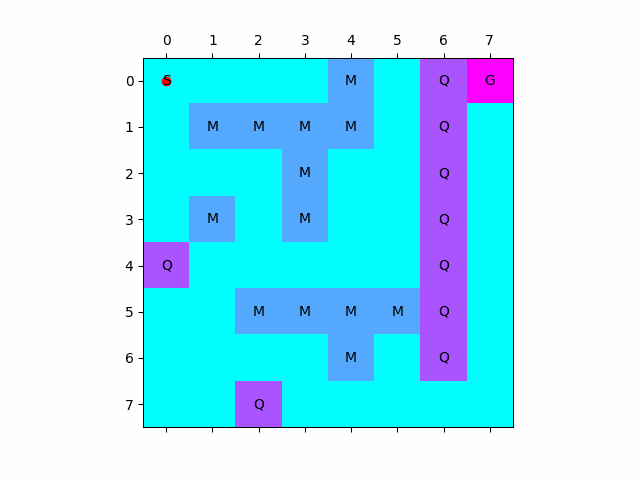

In [ ]:
# @title
#Exibe solução
display_combined_explanation_and_table(gw, policy, path, history, gif_filepath)